In [22]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xrft
import math 
import h5py

In [23]:
import h5py

# Open the file
filename = "ocean_climate_simulation_serial_integrated.jld2"
with h5py.File(filename, 'r') as f:
    # Print all keys in the file (to see top-level structure)
    print(f.keys())
    
    # Recursively print keys for nested groups if necessary
    def print_structure(group, indent=0):
        for key in group:
            item = group[key]
            print("  " * indent + key)
            if isinstance(item, h5py.Group):
                print_structure(item, indent + 1)
    
    print_structure(f)


<KeysViewHDF5 ['_types', 'buoyancy', 'closure', 'coriolis', 'grid', 'serialized', 'timeseries']>
_types
  00000001
  00000002
  00000003
  00000004
  00000005
  00000006
  00000007
  00000008
  00000009
  00000010
  00000011
  00000012
  00000013
  00000014
  00000015
  00000016
  00000017
  00000018
  00000019
  00000020
  00000021
  00000022
  00000023
  00000024
  00000025
  00000026
  00000027
  00000028
  00000029
  00000030
  00000031
  00000032
  00000033
  00000034
  00000035
  00000036
buoyancy
  formulation
    equation_of_state
      reference_density
    gravitational_acceleration
closure
  maximum_tke_diffusivity
  maximum_tracer_diffusivity
  maximum_viscosity
  minimum_convective_buoyancy_flux
  minimum_tke
  mixing_length
    CRiᵟ
    CRi⁰
    Cʰⁱc
    Cʰⁱe
    Cʰⁱu
    Cˡᵒc
    Cˡᵒe
    Cˡᵒu
    Cˢ
    Cˢᵖ
    Cᵇ
    Cᵉc
    Cᵉe
    Cᵉu
    Cᵘⁿc
    Cᵘⁿe
    Cᵘⁿu
    Cᶜc
    Cᶜe
    Cᶜu
  negative_tke_damping_time_scale
  turbulent_kinetic_energy_equation
    CʰⁱD
    

## Extract 1D velocity spectrum

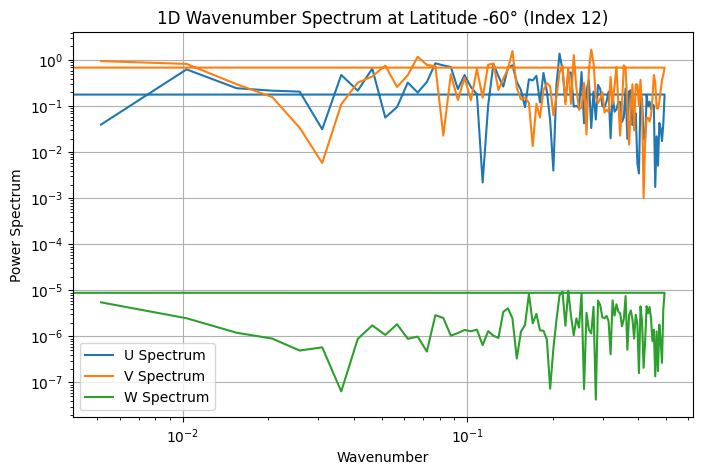

In [24]:
# after mapping latitude to correct index in dataset
def extract_velocity_spectrum(filename, latitude):
    """
    Extracts and plots the 1D wavenumber spectrum along a fixed latitude.

    Parameters:
    - filename: str, path to the JLD2 file.
    - latitude: float, the physical latitude to analyze.
    """
    with h5py.File(filename, 'r') as f:
        timeseries_group = f['timeseries']

        # Filter out non-numeric keys and get the last timestep
        timesteps = [key for key in timeseries_group['u'].keys() if key.isdigit()]
        last_timestep = sorted(timesteps, key=int)[-1]  # Get the latest numerical timestep

        # Load velocity data at the last timestep
        u_data = timeseries_group['u'][last_timestep][0]  # Shape (99, 194)
        v_data = timeseries_group['v'][last_timestep][0]
        w_data = timeseries_group['w'][last_timestep][0]

        # Assume latitudes range from -80 to 90 based on the tripolar mask
        Ny = u_data.shape[0]  # Get number of latitude points
        latitudes = np.linspace(-80, 90, Ny)  # Generate latitudes

        # Find closest latitude index
        latitude_idx = np.argmin(np.abs(latitudes - latitude))

        # Extract velocity at the given latitude
        u_at_latitude = u_data[latitude_idx, :]
        v_at_latitude = v_data[latitude_idx, :]
        w_at_latitude = w_data[latitude_idx, :]

        # Compute the 1D wavenumber spectrum
        kx = np.fft.fftfreq(len(u_at_latitude))  # Wavenumbers
        u_spectrum = np.abs(np.fft.fft(u_at_latitude))**2
        v_spectrum = np.abs(np.fft.fft(v_at_latitude))**2
        w_spectrum = np.abs(np.fft.fft(w_at_latitude))**2

        # Plot the spectrum
        plt.figure(figsize=(8, 5))
        plt.loglog(kx[1:], u_spectrum[1:], label='U Spectrum')
        plt.loglog(kx[1:], v_spectrum[1:], label='V Spectrum')
        plt.loglog(kx[1:], w_spectrum[1:], label='W Spectrum')
        plt.xlabel('Wavenumber')
        plt.ylabel('Power Spectrum')
        plt.legend()
        plt.title(f'1D Wavenumber Spectrum at Latitude {latitude}° (Index {latitude_idx})')
        plt.grid()
        plt.show()

# Example usage
filename = "ocean_climate_simulation_serial_surface.jld2"
latitude = -60  # Physical latitude in degrees
extract_velocity_spectrum(filename, latitude)

## Extract 1D spectrum

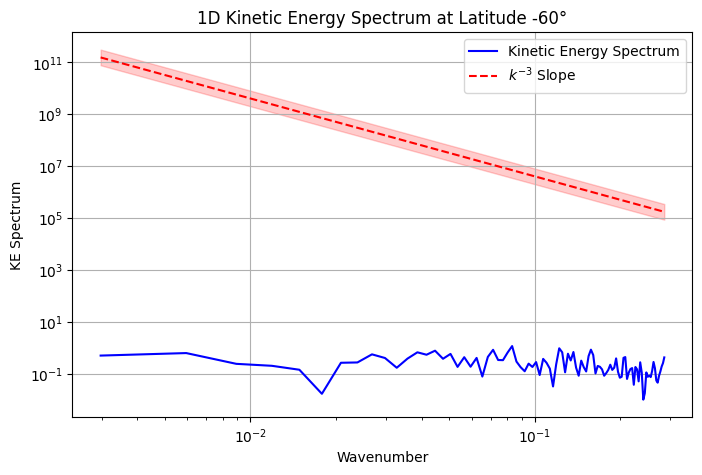

In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

def extract_ke_spectrum(filename, latitude):
    """
    Extracts and plots the 1D kinetic energy spectrum along a fixed latitude.

    Parameters:
    - filename: str, path to the JLD2 file.
    - latitude: float, the physical latitude to analyze.
    """
    with h5py.File(filename, 'r') as f:
        timeseries_group = f['timeseries']

        # Get the last numerical timestep
        timesteps = [key for key in timeseries_group['u'].keys() if key.isdigit()]
        last_timestep = sorted(timesteps, key=int)[-1]

        # Load velocity data (shape: Ny × Nx)
        u_data = timeseries_group['u'][last_timestep][0]
        v_data = timeseries_group['v'][last_timestep][0]

        # Define the latitude grid (assuming this is a tripolar grid)
        Ny = u_data.shape[0]
        latitudes = np.linspace(-80, 90, Ny)  

        # Find the closest latitude index
        latitude_idx = np.argmin(np.abs(latitudes - latitude))

        # Extract velocity at the given latitude
        u_at_latitude = u_data[latitude_idx, :]
        v_at_latitude = v_data[latitude_idx, :]

        # Compute the eddy velocity components (subtract the mean)
        u_eddy = detrend(u_at_latitude)
        v_eddy = detrend(v_at_latitude)

        # Compute the kinetic energy spectrum
        u_hat = np.fft.fft(u_eddy)
        v_hat = np.fft.fft(v_eddy)
        ke_spectrum = 0.5 * (np.abs(u_hat)**2 + np.abs(v_hat)**2)

        # Compute the distance between latitudes (non-uniform spacing)
        delta_latitudes = np.diff(latitudes)  # Latitude spacing differences

        # Compute wavenumbers considering non-uniform spacing
        # Normalize by the mean distance between latitudes
        kx = np.fft.fftfreq(len(u_eddy), d=delta_latitudes.mean())

        kx = kx[1:len(kx)//2]  
        ke_spectrum = ke_spectrum[1:len(ke_spectrum)//2]  # Keep corresponding spectrum

        ref_k = 20  
        ref_slope = ke_spectrum[0] * (kx / ref_k) ** (-3)  # Normalize to match energy scale

        plt.figure(figsize=(8, 5))
        plt.loglog(kx, ke_spectrum, label='Kinetic Energy Spectrum', color='blue')
        plt.loglog(kx, ref_slope, '--', label=r'$k^{-3}$ Slope', color='red')

        plt.fill_between(kx, ref_slope * 0.5, ref_slope * 2, color='red', alpha=0.2)

        plt.xlabel('Wavenumber')
        plt.ylabel('KE Spectrum')
        #plt.ylim([1, 1e5])
        plt.legend()
        plt.title(f'1D Kinetic Energy Spectrum at Latitude {latitude}°')
        plt.grid()
        plt.show()

# Example usage
filename = "ocean_climate_simulation_serial_surface.jld2"
latitude = -60  # Choose the latitude
extract_ke_spectrum(filename, latitude)

## Extract 2D spectrum

/tmp/ipykernel_1743863/2450801544.py:64: RuntimeWarning: divide by zero encountered in power
  ref_slope = E_mean[0] * (kx / ref_k) ** (-3)  # Normalize to match energy scale


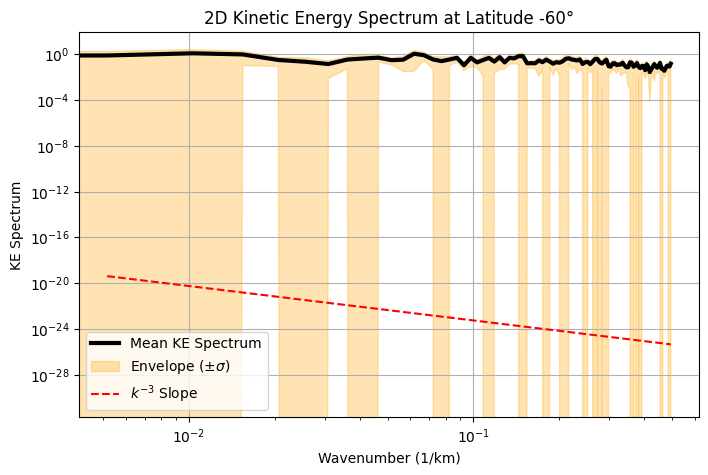

In [26]:
def extract_ke_spectrum_2d(filename, latitude):
    """
    Extracts and plots the 2D kinetic energy spectrum along a fixed latitude.
    Includes time averaging and standard deviation over multiple time steps.
    
    Parameters:
    - filename: str, path to the HDF5 file.
    - latitude: float, the physical latitude to analyze.
    """
    with h5py.File(filename, 'r') as f:
        timeseries_group = f['timeseries']

        # Get all available timesteps
        timesteps = [key for key in timeseries_group['u'].keys() if key.isdigit()]
        
        u_spectra = []
        v_spectra = []
        
        # Loop through timesteps and extract spectra
        for timestep in timesteps:
            # Load velocity data for each timestep (shape: Ny × Nx)
            u_data = timeseries_group['u'][timestep][0]
            v_data = timeseries_group['v'][timestep][0]

            # Define the latitude grid (assuming this is a tripolar grid)
            Ny = u_data.shape[0]
            latitudes = np.linspace(-80, 90, Ny)  # Assuming tripolar grid

            # Find the closest latitude index
            latitude_idx = np.argmin(np.abs(latitudes - latitude))

            # Extract velocity at the given latitude
            u_at_latitude = u_data[latitude_idx, :]
            v_at_latitude = v_data[latitude_idx, :]

            # Compute the eddy velocity components (subtract the mean)
            u_eddy = detrend(u_at_latitude)
            v_eddy = detrend(v_at_latitude)

            # Compute the kinetic energy spectrum for this timestep
            u_hat = np.fft.fft(u_eddy)
            v_hat = np.fft.fft(v_eddy)
            ke_spectrum = 0.5 * (np.abs(u_hat)**2 + np.abs(v_hat)**2)

            # Store the spectra for later averaging
            u_spectra.append(ke_spectrum)
            v_spectra.append(ke_spectrum)

        # Convert to numpy arrays
        u_spectra = np.array(u_spectra)
        v_spectra = np.array(v_spectra)

        # Compute the time-averaged spectrum and standard deviation
        E_mean = np.mean(u_spectra + v_spectra, axis=0) / 2  # Average over time
        E_std = np.std(u_spectra + v_spectra, axis=0) / 2  # Standard deviation

        # Compute wavenumbers (assuming uniform grid spacing in x-direction)
        Ny, Nx = u_data.shape
        dx = 1  # Assuming uniform spacing in x-direction
        kx = np.fft.fftfreq(Nx, d=dx)[:Nx//2]  # Positive wavenumbers only (half the length)

        # Reference k^-3 slope
        ref_k = 20
        ref_slope = E_mean[0] * (kx / ref_k) ** (-3)  # Normalize to match energy scale

        # Plot the KE spectrum
        plt.figure(figsize=(8, 5))
        plt.loglog(kx, E_mean[:len(kx)], label='Mean KE Spectrum', color='black', linewidth=3)
        plt.fill_between(kx, E_mean[:len(kx)] - E_std[:len(kx)], E_mean[:len(kx)] + E_std[:len(kx)], 
                         color='orange', alpha=0.3, label=r"Envelope ($\pm \sigma$)")

        # Plot the k^-3 reference slope
        plt.loglog(kx, ref_slope, '--', label=r'$k^{-3}$ Slope', color='red')

        plt.xlabel('Wavenumber (1/km)')
        plt.ylabel('KE Spectrum')
        plt.legend()
        plt.title(f'2D Kinetic Energy Spectrum at Latitude {latitude}°')
        plt.grid(True)
        plt.show()

# Example usage
filename = "ocean_climate_simulation_serial_surface.jld2"
latitude = -60  # Choose the latitude
extract_ke_spectrum_2d(filename, latitude)

## Attempt to use tripolar grid rather than use assumptions

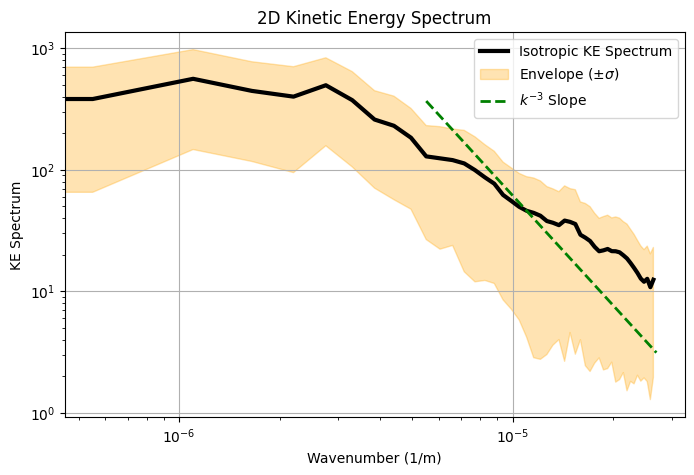

In [42]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.signal import detrend

def extract_ke_spectrum_2d(filename):
    """
    Computes and plots the 2D kinetic energy spectrum using velocity fields
    on a tripolar grid. It includes a k^-3 slope and the envelope of ±σ.
    
    Parameters:
    - filename: str, path to the JLD2 file.
    """
    with h5py.File(filename, 'r') as f:
        timeseries_group = f['timeseries']
        
        # Extract grid spacings (extracting from JLD2 is tricky)
        dx = np.array(f['grid/underlying_grid/Δxᶜᶜᵃ'])  # Zonal spacing
        dy = np.array(f['grid/underlying_grid/Δyᶜᶜᵃ'])  # Meridional spacing

        # Get available timesteps
        timesteps = [key for key in timeseries_group['u'].keys() if key.isdigit()]

        ke_spectra = []

        for timestep in timesteps:
            # Load velocity data (shape: Ny × Nx)
            u_data = timeseries_group['u'][timestep][0]
            v_data = timeseries_group['v'][timestep][0]

            # Remove the mean trend to focus on eddy components
            u_eddy = detrend(u_data, axis=1, type='linear')
            v_eddy = detrend(v_data, axis=1, type='linear')

            # Compute 2D FFT
            u_hat = np.fft.fft2(u_eddy)
            v_hat = np.fft.fft2(v_eddy)
            
            # Compute 2D KE spectrum
            ke_spectrum = 0.5 * (np.abs(u_hat)**2 + np.abs(v_hat)**2)
            ke_spectra.append(ke_spectrum)

        # Time-average the KE spectrum
        ke_spectra = np.array(ke_spectra)
        E_mean = np.mean(ke_spectra, axis=0)
        E_std = np.std(ke_spectra, axis=0)  # Standard deviation

        # Compute wavenumbers
        Ny, Nx = u_data.shape
        kx = np.fft.fftfreq(Nx, d=np.mean(dx)) * (2 * np.pi)  # Convert to rad/m
        ky = np.fft.fftfreq(Ny, d=np.mean(dy)) * (2 * np.pi)

        kx, ky = np.meshgrid(kx, ky)
        k_magnitude = np.sqrt(kx**2 + ky**2)

        # Convert the 2D spectrum into an isotropic spectrum
        k_bins = np.linspace(k_magnitude.min(), k_magnitude.max(), 50)
        E_iso = np.zeros(len(k_bins) - 1)
        E_std_iso = np.zeros(len(k_bins) - 1)

        for i in range(len(k_bins) - 1):
            mask = (k_magnitude >= k_bins[i]) & (k_magnitude < k_bins[i+1])
            E_iso[i] = np.mean(E_mean[mask])
            E_std_iso[i] = np.mean(E_std[mask])

        # Plot isotropic KE spectrum with envelope of +/- sigma
        plt.figure(figsize=(8, 5))
        plt.loglog(k_bins[:-1], E_iso, label='Isotropic KE Spectrum', color='black', linewidth=3)
        plt.fill_between(k_bins[:-1], E_iso - E_std_iso, E_iso + E_std_iso, 
                         color='orange', alpha=0.3, label=r"Envelope ($\pm \sigma$)")

        # Add k^-3 slope
        ref_k = 20  # Choose a reference wavenumber for the k^-3 slope
        k_ref = k_bins[ref_k]  # Reference wavenumber
        E_ref = E_iso[ref_k]   # Corresponding reference energy
        k_slope = np.linspace(k_bins[10], k_bins[-1], 10)  # Generate wavenumber range
        E_slope = E_ref * (k_slope / k_ref) ** -3  # Compute k^-3 power law
        plt.plot(k_slope, E_slope, linestyle="--", color="green", linewidth=2, label=r"$k^{-3}$ Slope")

        plt.xlabel('Wavenumber (1/m)')
        plt.ylabel('KE Spectrum')
        plt.legend()
        plt.title('2D Kinetic Energy Spectrum')
        plt.grid(True)
        plt.show()

# Example usage
filename = "ocean_climate_simulation_serial_surface.jld2"
extract_ke_spectrum_2d(filename)